# Imports

In [1]:
from datetime import datetime
import pandas as pd

from diive.core.io.files import load_parquet, save_parquet
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS

# Load data

In [2]:
df = load_parquet(filepath="17.1_CH-CHA_meteo10_2005-2024.parquet")
df

Loaded .parquet file 17.1_CH-CHA_meteo10_2005-2024.parquet (0.048 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


,LW_IN_T1_2_1,PA_GF1_0.9_1,FLAG_PA_GF1_0.9_1_ISFILLED,PPFD_IN_T1_2_2,FLAG_PPFD_IN_T1_2_2_ISFILLED,VPD_T1_2_1,...,SWC_GF1_0.75_1,TS_GF1_0.04_1,TS_GF1_0.15_1,TS_GF1_0.4_1,FLAG_PREC_RAIN_TOT_GF1_0.5_1_FLUXNET_ISFILLED,TIMESINCE_PREC_RAIN_TOT_GF1_0.5_1
TIMESTAMP_MIDDLE,,,,,,,,,,,,,
2005-01-01 00:15:00,NaN,978.100000,1.0,0.0,0,0.099893,...,NaN,NaN,NaN,NaN,NaN,1
2005-01-01 00:45:00,NaN,977.933333,1.0,0.0,0,0.097606,...,NaN,NaN,NaN,NaN,NaN,2
2005-01-01 01:15:00,NaN,977.900000,1.0,0.0,0,0.091683,...,NaN,NaN,NaN,NaN,NaN,0
2005-01-01 01:45:00,NaN,977.833333,1.0,0.0,0,0.071157,...,NaN,NaN,NaN,NaN,NaN,1
2005-01-01 02:15:00,NaN,977.833333,1.0,0.0,0,0.058333,...,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 21:45:00,304.613900,983.370890,NaN,0.0,0,0.000011,...,45.120877,3.474346,4.437078,5.528727,NaN,380
2024-12-31 22:15:00,303.039890,983.052160,NaN,0.0,0,0.000011,...,45.144937,3.428224,4.440415,5.521962,NaN,381
2024-12-31 22:45:00,302.093633,982.851140,NaN,0.0,0,0.000011,...,45.152280,3.384733,4.443751,5.523991,NaN,382


# Gap-filling `TS`

In [3]:
[print(c) for c in df if "TS_" in c];

TS_GF1_0.04_1
TS_GF1_0.15_1
TS_GF1_0.4_1


## Fill `TS_GF1_0.04_1`


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 350640.

Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-09-09 10:15:00 and 2024-12-31 23:15:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:4.77951	validation_1-rmse:4.77196
[1]	validation_0-rmse:3.50458	validation_1-rmse:3.49880
[2]	validation_0-rmse:2.64362	validation_1-rmse:2.64112
[3]	validation_0-rmse:2.07531	validation_1-rmse:2.07526
[4]	validation_0-rmse:1.70842	validation_1-rmse:1.71063
[5]	validation_0-rmse:1.47499	validation_1-rmse:1.47882
[6]	validation_0-rmse:1.33445	validation_1-rmse:1.33946
[7]	validation_0-rmse:1.22991	validation_1-rmse:1.23687
[8]	validation_0-rmse:1.16118	validation_1-rmse:1.16975
[9]	validation_0-rmse:1.11181	validation_1-rmse:1.12216
[10]	va

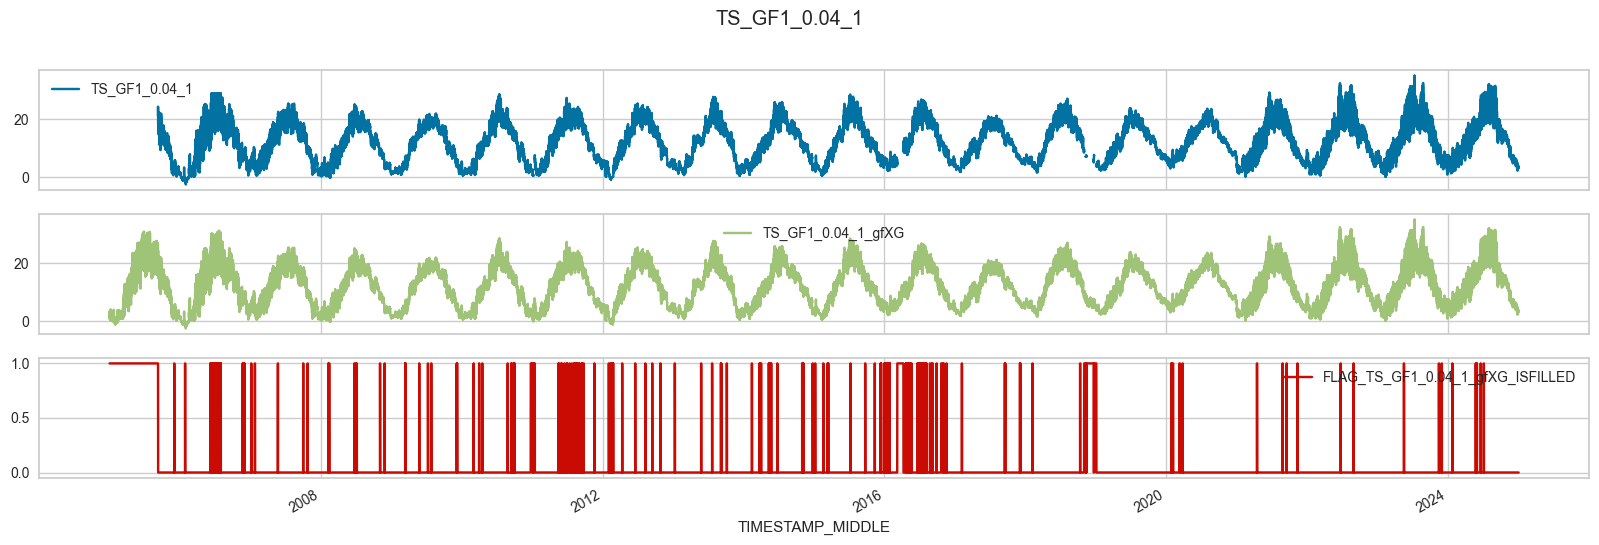

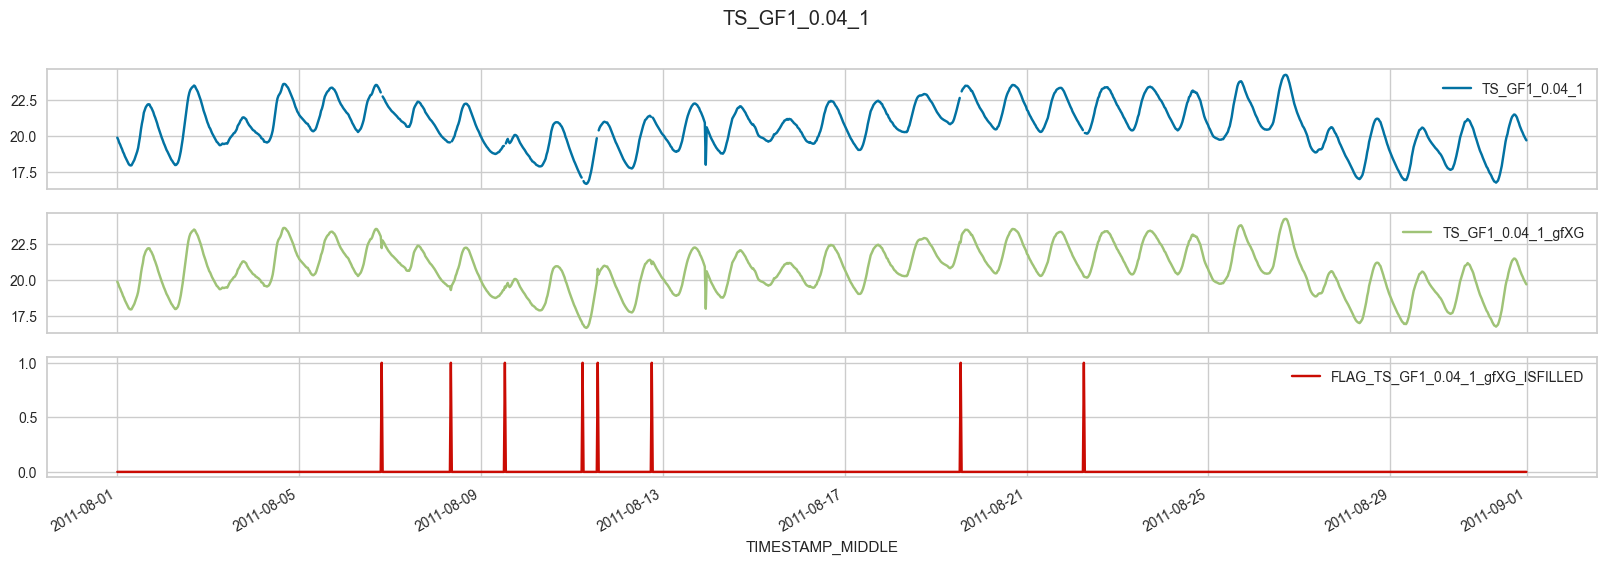

In [4]:
TARGET_COL = 'TS_GF1_0.04_1'
TARGET_GAPFILLED_COL = f'{TARGET_COL}_gfXG'
FLAG_GAPFILLED_COL = f'FLAG_{TARGET_GAPFILLED_COL}_ISFILLED'

# Dataframe for gap-filling
_df = pd.DataFrame()
_df[TARGET_COL] = df[TARGET_COL].copy()
_df['TA_T1_2_1'] = df['TA_T1_2_1'].copy()

# XGBoost
xgb = XGBoostTS(
    input_df=_df,
    target_col=TARGET_COL,
    features_lag=[-5, -1],
    features_lag_exclude_cols=None,
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()
results = xgb.gapfilling_df_

# Add results to main data
df = pd.concat([df, results[[TARGET_GAPFILLED_COL, FLAG_GAPFILLED_COL]]], axis=1)

# Plot
plotdf = df[[TARGET_COL, TARGET_GAPFILLED_COL, FLAG_GAPFILLED_COL]].copy()
plotdf.plot(x_compat=True, title=TARGET_COL, subplots=True, figsize=(20, 6));
locs = (plotdf.index.year == 2011) & (plotdf.index.month == 8)
plotdf[locs].plot(x_compat=True, title=TARGET_COL, subplots=True, figsize=(20, 6));

## Fill `TS_GF1_0.15_1`


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 350640.

Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-09-09 10:15:00 and 2024-12-31 23:45:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:4.37232	validation_1-rmse:4.37077
[1]	validation_0-rmse:3.10113	validation_1-rmse:3.10008
[2]	validation_0-rmse:2.21736	validation_1-rmse:2.21684
[3]	validation_0-rmse:1.60544	validation_1-rmse:1.60533
[4]	validation_0-rmse:1.18834	validation_1-rmse:1.18870
[5]	validation_0-rmse:0.90868	validation_1-rmse:0.90974
[6]	validation_0-rmse:0.72410	validation_1-rmse:0.72602
[7]	validation_0-rmse:0.60477	validation_1-rmse:0.60718
[8]	validation_0-rmse:0.52486	validation_1-rmse:0.52731
[9]	validation_0-rmse:0.47675	validation_1-rmse:0.47987
[10]	va

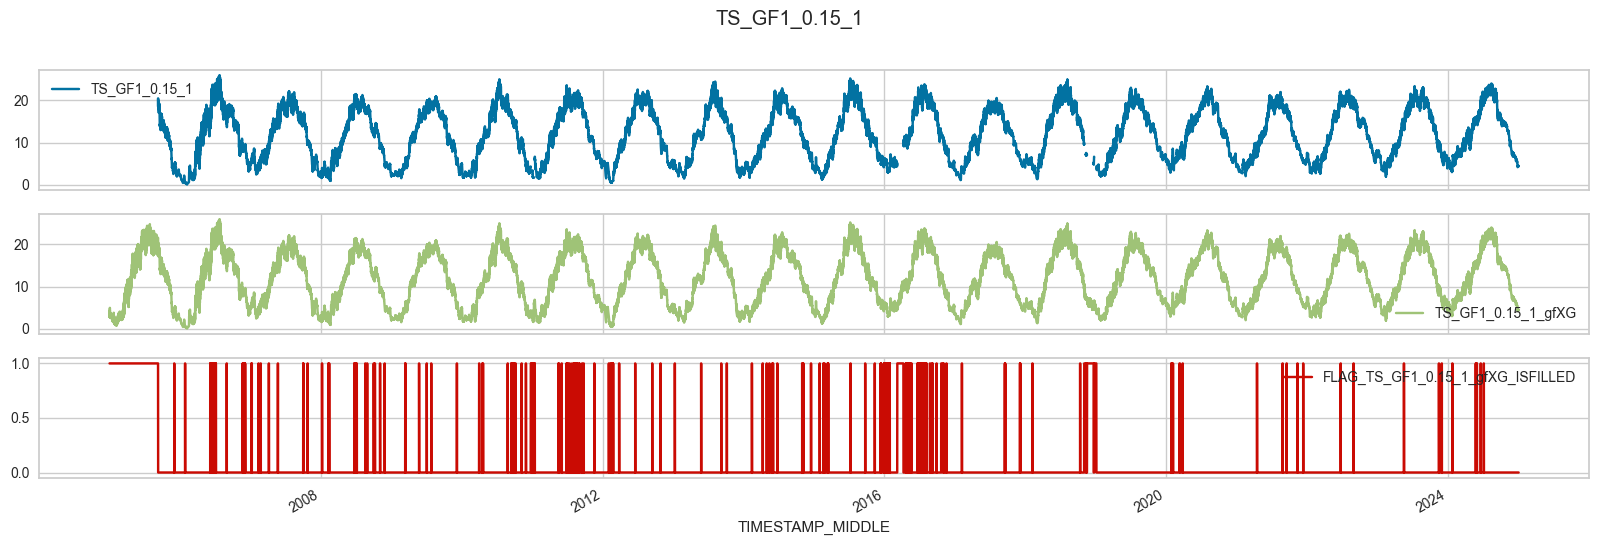

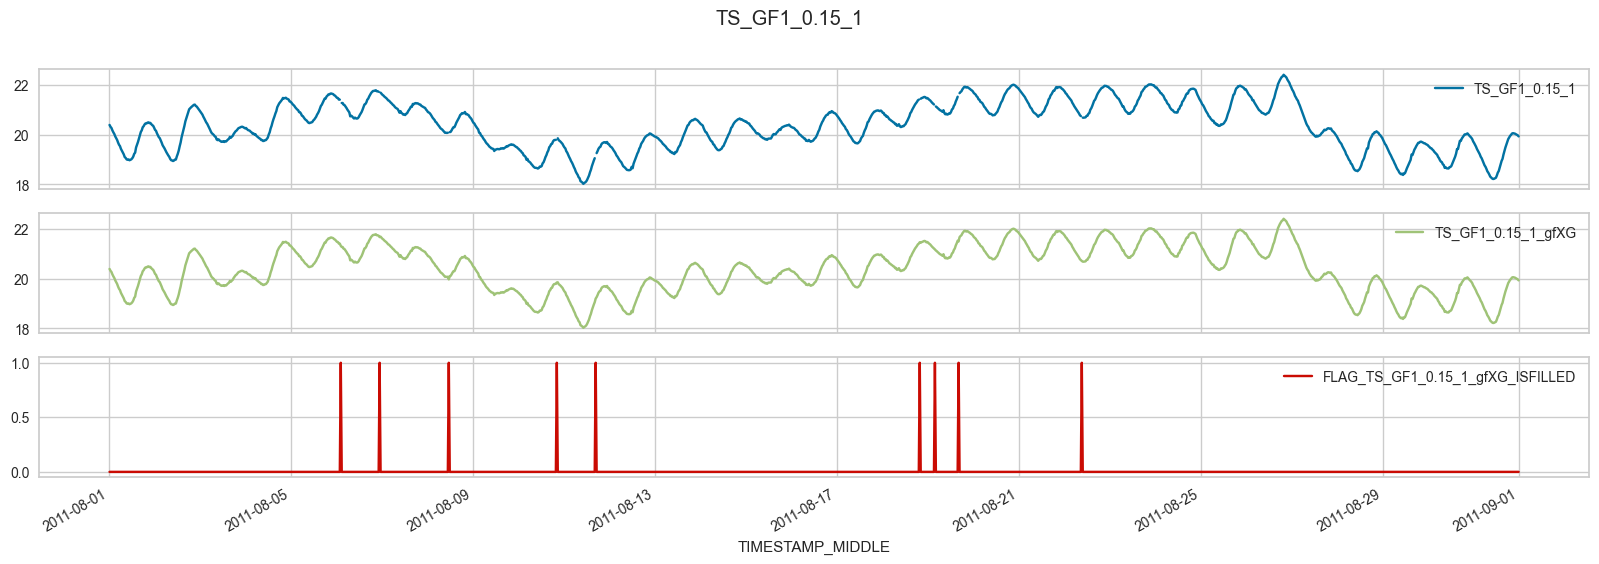

In [5]:
TARGET_COL = 'TS_GF1_0.15_1'
TARGET_GAPFILLED_COL = f'{TARGET_COL}_gfXG'
FLAG_GAPFILLED_COL = f'FLAG_{TARGET_GAPFILLED_COL}_ISFILLED'

# Dataframe for gap-filling
_df = pd.DataFrame()
_df[TARGET_COL] = df[TARGET_COL].copy()
_df['TS_GF1_0.04_1_gfXG'] = df['TS_GF1_0.04_1_gfXG'].copy()

# XGBoost
xgb = XGBoostTS(
    input_df=_df,
    target_col=TARGET_COL,
    features_lag=[-10, -1],
    features_lag_exclude_cols=None,
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()
results = xgb.gapfilling_df_

# Add results to main data
df = pd.concat([df, results[[TARGET_GAPFILLED_COL, FLAG_GAPFILLED_COL]]], axis=1)

# Plot
plotdf = df[[TARGET_COL, TARGET_GAPFILLED_COL, FLAG_GAPFILLED_COL]].copy()
plotdf.plot(x_compat=True, title=TARGET_COL, subplots=True, figsize=(20, 6));
locs = (plotdf.index.year == 2011) & (plotdf.index.month == 8)
plotdf[locs].plot(x_compat=True, title=TARGET_COL, subplots=True, figsize=(20, 6));

## Fill `TS_GF1_0.4_1`


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 350640.

Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-09-09 10:15:00 and 2024-12-31 23:15:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:3.84965	validation_1-rmse:3.84616
[1]	validation_0-rmse:2.71625	validation_1-rmse:2.71394
[2]	validation_0-rmse:1.92710	validation_1-rmse:1.92541
[3]	validation_0-rmse:1.38134	validation_1-rmse:1.38024
[4]	validation_0-rmse:1.00683	validation_1-rmse:1.00627
[5]	validation_0-rmse:0.75413	validation_1-rmse:0.75427
[6]	validation_0-rmse:0.58644	validation_1-rmse:0.58703
[7]	validation_0-rmse:0.47932	validation_1-rmse:0.48022
[8]	validation_0-rmse:0.40890	validation_1-rmse:0.41008
[9]	validation_0-rmse:0.36666	validation_1-rmse:0.36809
[10]	va

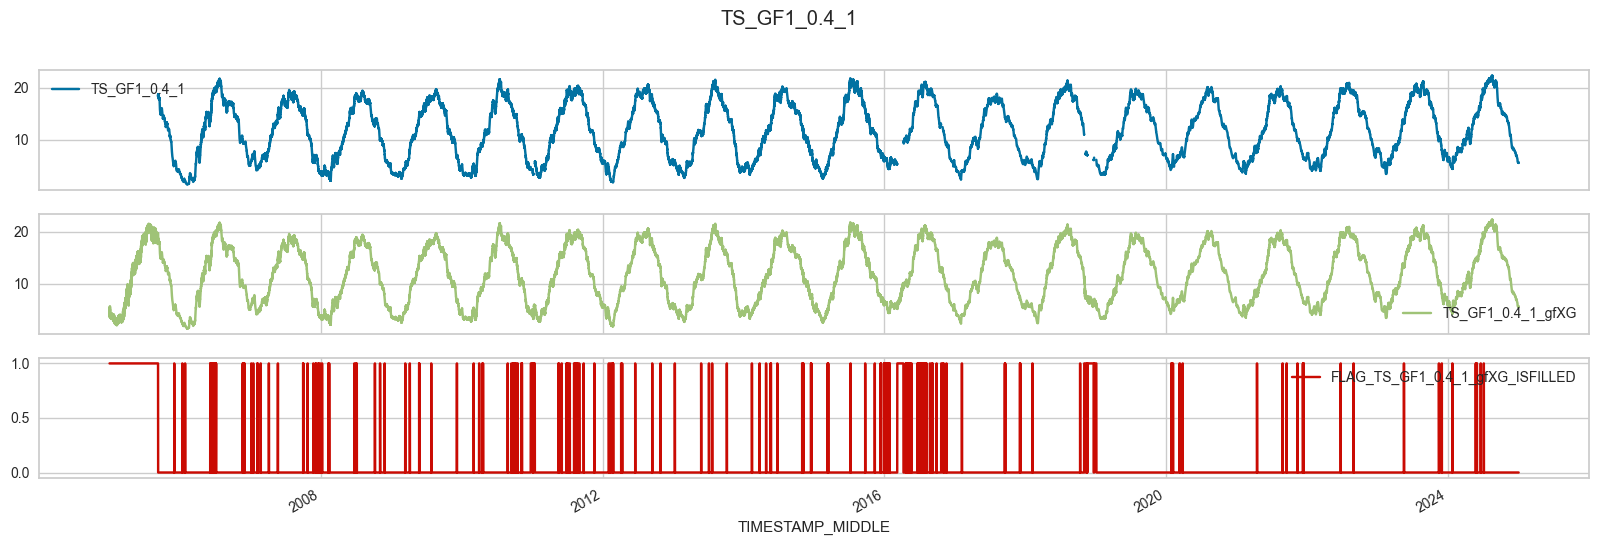

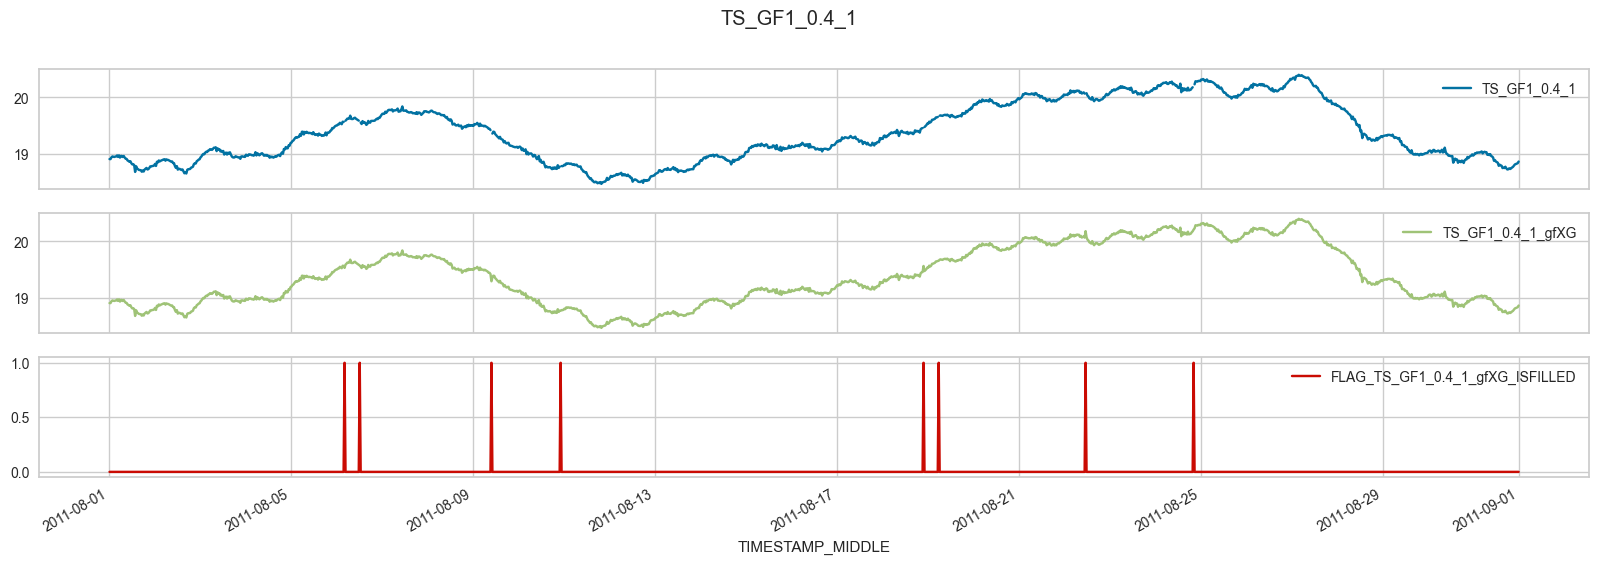

In [6]:
TARGET_COL = 'TS_GF1_0.4_1'
TARGET_GAPFILLED_COL = f'{TARGET_COL}_gfXG'
FLAG_GAPFILLED_COL = f'FLAG_{TARGET_GAPFILLED_COL}_ISFILLED'

# Dataframe for gap-filling
_df = pd.DataFrame()
_df[TARGET_COL] = df[TARGET_COL].copy()
_df['TS_GF1_0.04_1_gfXG'] = df['TS_GF1_0.04_1_gfXG'].copy()
_df['TS_GF1_0.15_1_gfXG'] = df['TS_GF1_0.15_1_gfXG'].copy()

# XGBoost
xgb = XGBoostTS(
    input_df=_df,
    target_col=TARGET_COL,
    features_lag=[-10, -1],
    features_lag_exclude_cols=None,
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()
results = xgb.gapfilling_df_

# Add results to main data
df = pd.concat([df, results[[TARGET_GAPFILLED_COL, FLAG_GAPFILLED_COL]]], axis=1)

# Plot
plotdf = df[[TARGET_COL, TARGET_GAPFILLED_COL, FLAG_GAPFILLED_COL]].copy()
plotdf.plot(x_compat=True, title=TARGET_COL, subplots=True, figsize=(20, 6));
locs = (plotdf.index.year == 2011) & (plotdf.index.month == 8)
plotdf[locs].plot(x_compat=True, title=TARGET_COL, subplots=True, figsize=(20, 6));

# Plot

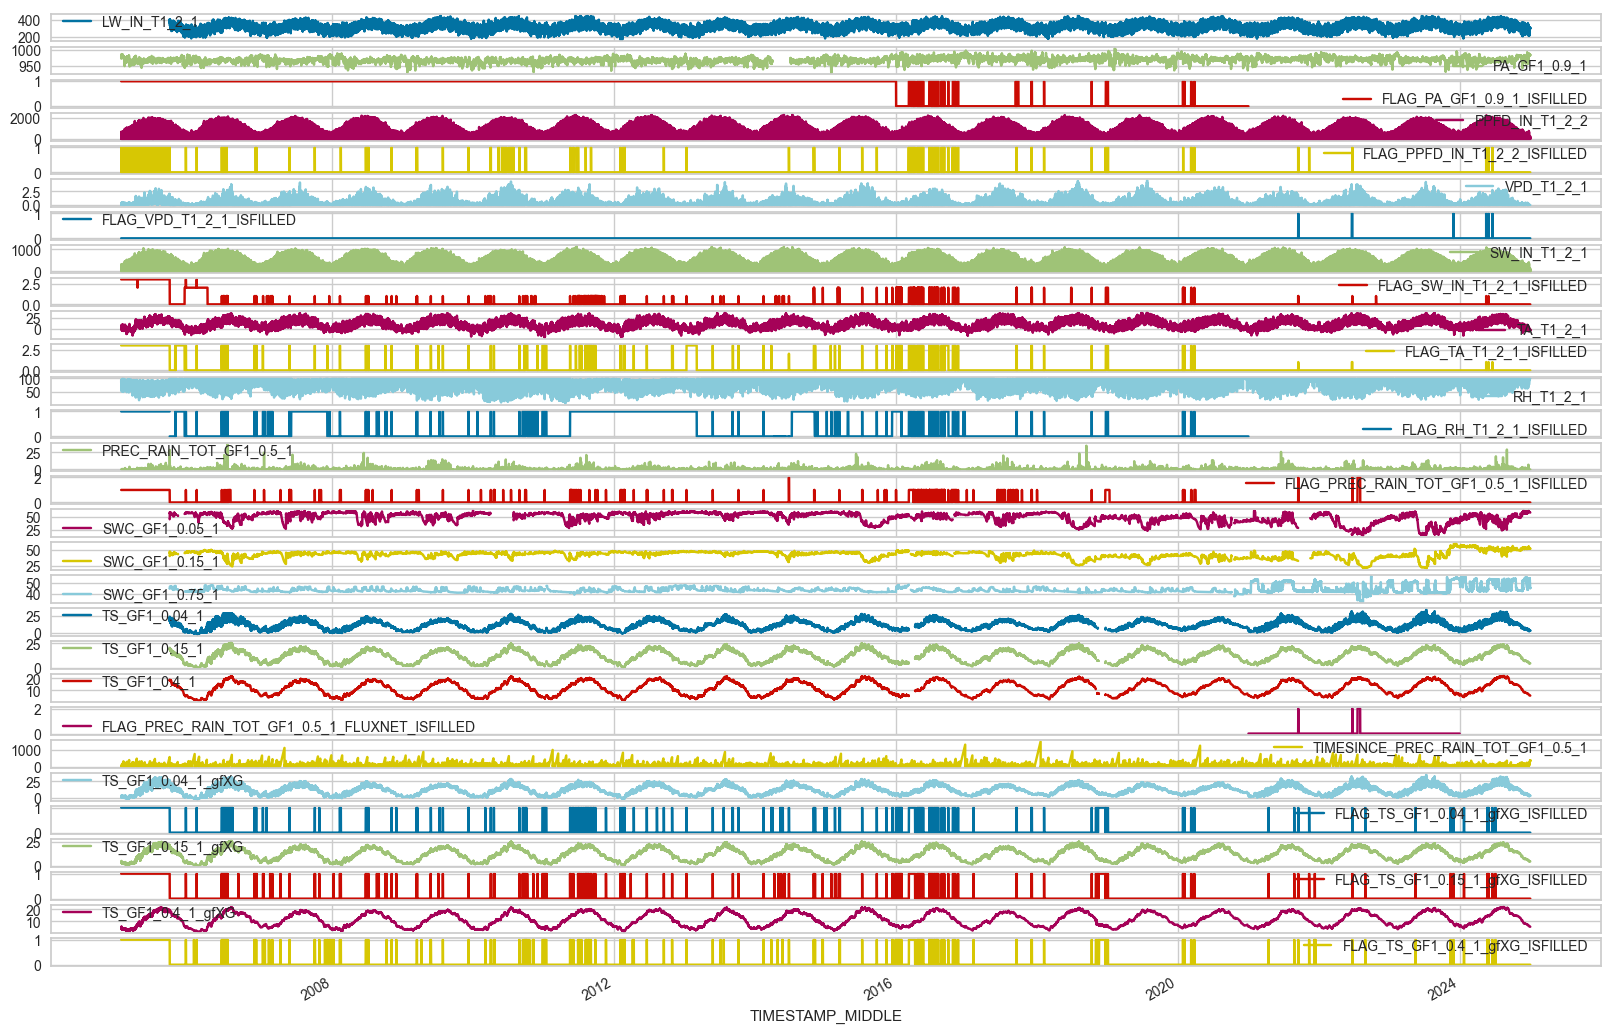

In [7]:
df.plot(x_compat=True, subplots=True, figsize=(20, 14));

# Save to file

In [8]:
OUTNAME = "17.3_CH-CHA_meteo10_2005-2024"
filepath = save_parquet(filename=OUTNAME, data=df)
# df.to_csv(f"{OUTNAME}.csv")

Saved file 17.3_CH-CHA_meteo10_2005-2024.parquet (0.406 seconds).


# **End of notebook**.

In [9]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2025-01-21 00:00:53
